# 基于计算机视觉的钢筋条数检测

数据集：钢筋进工地现场的图片和标注文件，250张训练，200张测试

实现方案：基于目标检测，检测出图片中钢筋的横截面，从而统计出钢筋的条数

### 1. test进入ModelArts
点击如下链接：https://www.huaweicloud.com/product/modelarts.html ， 进入ModelArts主页。点击“进入控制台”按钮，输入用户名和密码登录，进入ModelArts使用页面

### 2. 创建Notebook
下面，我们在ModelArts中创建一个Notebook开发环境，Notebook提供网页版的Python开发环境，可以方便的编写、运行代码，并查看运行结果。

（1）在ModelArts服务主界面依次点击“开发环境”、“创建”
![create_nb_create_button](./img/create_nb_create_button.png)

（2）填写创建Notebook所需的参数，“类型” 选择 “GPU”，“规格” 选择 “\[限时免费\]体验规格GPU版” 或 “GPU：1\*v100NV32 CPU: 8核64GiB”，其他参数保持默认即可，点击下一步，提交，返回Notebook列表，等待Notebook创建完成，一般耗时1~2分钟

### 3. 打开Notebook，上传本期案例文档
（1）等待Notebook的状态变成“运行中”后，点击下图所示的“打开”按钮，进入刚刚创建的Notebook。
![open_notebook](img/open_notebook.png)

（2）[点此链接](https://modelarts-labs-bj4.obs.cn-north-4.myhuaweicloud.com:443/notebook/DL_rebar_count.zip)下载本案例文档DL_rebar_count.zip到自己的本机，然后按照下图点击“upload”上传压缩包到Notebook中。
![upload_zip](img/upload_zip.png)

（3）按照下图新建一个Terminal
![open_terminal](img/open_terminal.png)

（4）按照下图执行 cd work 进入work目录，再执行 unzip DL_rebar_count.zip，将压缩包进行解压
![unzip_file](img/unzip_file.png)

（5）回到Notebook文件管理页面，在DL_rebar_count目录下打开rebar_count.ipynb文件，进入今天的案例
![open_ipynb](./img/open_ipynb.png)

# 数钢筋案例开始 - 下载代码和数据集

In [1]:
import os
import moxing as mox
if not os.path.exists('./rebar_count'):
    print('Downloading code and datasets...')
    mox.file.copy('s3://modelarts-labs-bj4/notebook/DL_rebar_count/rebar_count.zip', './rebar_count.zip')
    os.system("unzip rebar_count.zip; rm rebar_count.zip")
    if os.path.exists('./rebar_count'):
        print('Download code and datasets success')
    else:
        print('Download code and datasets failed, please check the download url is valid or not.')
else:
    print('./rebar_count already exists')

INFO:root:Using MoXing-v1.17.3-
INFO:root:Using OBS-Python-SDK-3.20.7


Download code and datasets success


# 加载需要的python模块

In [2]:
import os
import sys
sys.path.insert(0, './rebar_count/src')
import cv2
import time
import random
import torch
import numpy as np
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
from datetime import datetime
from collections import OrderedDict
import torch.optim as optim
import torch.utils.data as data
import torch.backends.cudnn as cudnn
from data import VOCroot, VOC_Config, AnnotationTransform, VOCDetection, detection_collate, BaseTransform, preproc
from models.RFB_Net_vgg import build_net
from layers.modules import MultiBoxLoss
from layers.functions import Detect, PriorBox
from utils.visualize import *
from utils.nms_wrapper import nms
from utils.timer import Timer
import matplotlib.pyplot as plt
%matplotlib inline
ROOT_DIR = os.getcwd()

seed = 0
cudnn.benchmark = False
cudnn.deterministic = True
torch.manual_seed(seed)            # 为CPU设置随机种子
torch.cuda.manual_seed_all(seed)   # 为所有GPU设置随机种子
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)  # 设置hash随机种子

INFO:matplotlib.font_manager:font search path ['/home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf', '/home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/afm', '/home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts']
INFO:matplotlib.font_manager:generated new fontManager


# 查看训练数据样例

In [3]:
def read_xml(xml_path):
    '''读取xml标签'''
    tree = ET.parse(xml_path)
    root = tree.getroot()
    boxes = []
    labels = []
    for element in root.findall('object'):
        label = element.find('name').text
        if label == 'steel':
            bndbox = element.find('bndbox')
            xmin = bndbox.find('xmin').text
            ymin = bndbox.find('ymin').text
            xmax = bndbox.find('xmax').text
            ymax = bndbox.find('ymax').text
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)
    return np.array(boxes, dtype=np.float64), labels

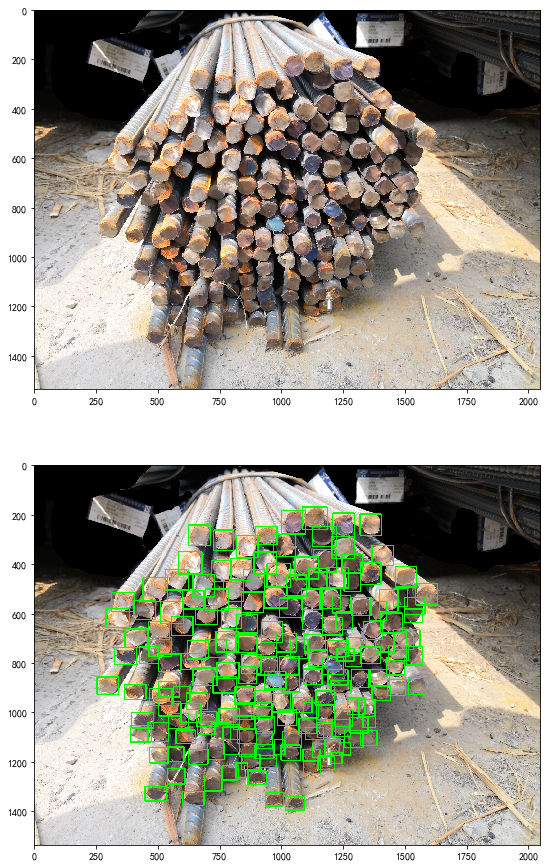

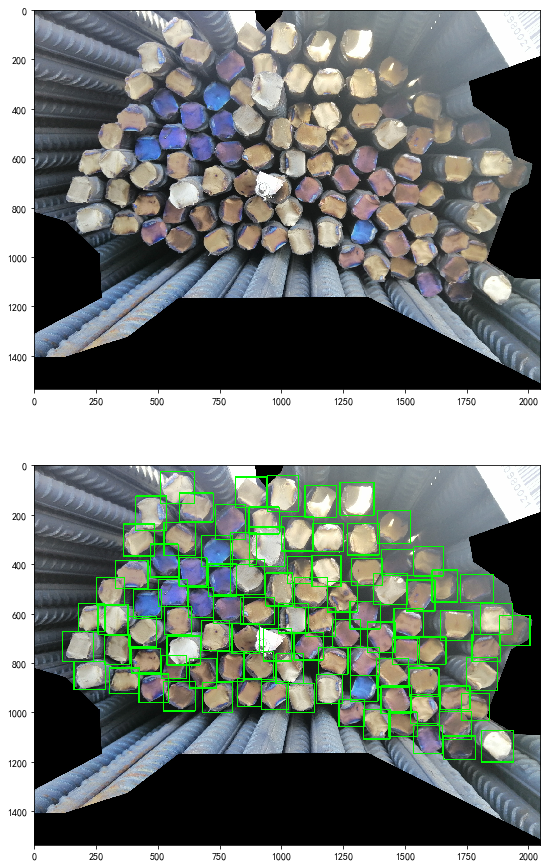

In [4]:
# 显示原图和标注框
train_img_dir = './rebar_count/datasets/VOC2007/JPEGImages'
train_xml_dir = './rebar_count/datasets/VOC2007/Annotations'
files = os.listdir(train_img_dir)
files.sort()
for index, file_name in enumerate(files[:2]):
    img_path = os.path.join(train_img_dir, file_name)
    xml_path = os.path.join(train_xml_dir, file_name.split('.jpg')[0] + '.xml')
    boxes, labels = read_xml(xml_path)
    img = Image.open(img_path)
    
    resize_scale = 2048.0 / max(img.size)
    img = img.resize((int(img.size[0] * resize_scale), int(img.size[1] * resize_scale)))
    boxes *= resize_scale
    
    plt.figure(figsize=(img.size[0]/100.0, img.size[1]/100.0))
    plt.subplot(2,1,1)
    plt.imshow(img)
    
    img = img.convert('RGB')
    img = np.array(img)
    img = img.copy()
    for box in boxes:
        xmin, ymin, xmax, ymax = box.astype(np.int)
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), thickness=3)
    
    plt.subplot(2,1,2)
    plt.imshow(img)
plt.show()

# 定义训练超参，模型、日志保存路径

In [5]:
# 定义训练超参
num_classes = 2  # 数据集中只有 steel 一个标签，加上背景，所以总共有2个类
max_epoch = 1  # 默认值为1，调整为大于20的值，训练效果更佳
batch_size = 8
ngpu = 1
initial_lr = 0.01
img_dim = 416  # 模型输入图片大小
train_sets = [('2007', 'trainval')]  # 指定训练集
cfg = VOC_Config
rgb_means = (104, 117, 123)  # ImageNet数据集的RGB均值

save_folder = './rebar_count/model_snapshots'  # 指定训练模型保存路径
if not os.path.exists(save_folder):
    os.mkdir(save_folder)
    
log_path = os.path.join('./rebar_count/logs', datetime.now().isoformat())  # 指定日志保存路径
if not os.path.exists(log_path):
    os.makedirs(log_path)

# 构建模型，定义优化器及损失函数

In [6]:
net = build_net('train', img_dim, num_classes=num_classes)

if ngpu > 1:
    net = torch.nn.DataParallel(net)

net.cuda()  # 本案例代码只能在GPU上训练
cudnn.benchmark = True

optimizer = optim.SGD(net.parameters(), lr=initial_lr,
                      momentum=0.9, weight_decay=0)  # 定义优化器

criterion = MultiBoxLoss(num_classes,
                         overlap_thresh=0.4,
                         prior_for_matching=True,
                         bkg_label=0,
                         neg_mining=True,
                         neg_pos=3,
                         neg_overlap=0.3,
                         encode_target=False)  # 定义损失函数

priorbox = PriorBox(cfg)
with torch.no_grad():
    priors = priorbox.forward()
    priors = priors.cuda()

# 定义自适应学习率函数

In [7]:
def adjust_learning_rate(optimizer, gamma, epoch, step_index, iteration, epoch_size):
    """
    自适应学习率
    """
    if epoch < 11:
        lr = 1e-8 + (initial_lr-1e-8) * iteration / (epoch_size * 10)
    else:
        lr = initial_lr * (gamma ** (step_index))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

# 定义训练函数

In [8]:
def train():
    """
    模型训练函数，每10次迭代打印一次日志，20个epoch之后，每个epoch保存一次模型
    """
    net.train()

    loc_loss = 0
    conf_loss = 0
    epoch = 0
    print('Loading dataset...')

    dataset = VOCDetection(VOCroot, train_sets, preproc(img_dim, rgb_means, p=0.0), AnnotationTransform())

    epoch_size = len(dataset) // batch_size
    max_iter = max_epoch * epoch_size

    stepvalues = (25 * epoch_size, 35 * epoch_size)
    step_index = 0
    start_iter = 0

    lr = initial_lr
    for iteration in range(start_iter, max_iter):
        if iteration % epoch_size == 0:
            if epoch > 20:
                torch.save(net.state_dict(), os.path.join(save_folder, 'epoch_' +
                           repr(epoch).zfill(3) + '_loss_'+ '%.4f' % loss.item() + '.pth'))

            batch_iterator = iter(data.DataLoader(dataset, batch_size,
                                                  shuffle=True, num_workers=8, collate_fn=detection_collate))
            loc_loss = 0
            conf_loss = 0
            epoch += 1

        load_t0 = time.time()
        if iteration in stepvalues:
            step_index += 1
        lr = adjust_learning_rate(optimizer, 0.2, epoch, step_index, iteration, epoch_size)


        images, targets = next(batch_iterator)

        images = Variable(images.cuda())
        targets = [Variable(anno.cuda()) for anno in targets]

        # forward
        t0 = time.time()
        out = net(images)
        # backprop
        optimizer.zero_grad()
        loss_l, loss_c = criterion(out, priors, targets)
        loss = loss_l + loss_c
        loss.backward()
        optimizer.step()
        t1 = time.time()
        loc_loss += loss_l.item()
        conf_loss += loss_c.item()
        load_t1 = time.time()

        if iteration % 10 == 0:
            print('Epoch:' + repr(epoch) + ' || epochiter: ' + repr(iteration % epoch_size) + '/' + repr(epoch_size)
                  + '|| Totel iter ' +
                  repr(iteration) + ' || L: %.4f C: %.4f||' % (
                loss_l.item(),loss_c.item()) +
                'Batch time: %.4f sec. ||' % (load_t1 - load_t0) + 'LR: %.8f' % (lr))

    torch.save(net.state_dict(), os.path.join(save_folder, 'epoch_' +
               repr(epoch).zfill(3) + '_loss_'+ '%.4f' % loss.item() + '.pth'))

# 开始训练，每个epoch训练耗时约18秒

In [9]:
t1 = time.time()
print('开始训练，本次训练总共需%d个epoch，每个epoch训练耗时约18秒' % max_epoch)
train()
print('training cost %.2f s' % (time.time() - t1))

开始训练，本次训练总共需1个epoch，每个epoch训练耗时约18秒
Loading dataset...
Epoch:1 || epochiter: 0/25|| Totel iter 0 || L: 3.7623 C: 3.6673||Batch time: 7.3054 sec. ||LR: 0.00000001
Epoch:1 || epochiter: 10/25|| Totel iter 10 || L: 3.6013 C: 3.1460||Batch time: 0.7580 sec. ||LR: 0.00040001
Epoch:1 || epochiter: 20/25|| Totel iter 20 || L: 2.7440 C: 2.3796||Batch time: 0.1298 sec. ||LR: 0.00080001
training cost 17.80 s


# 已完成训练，下面开始测试模型，首先需定义目标检测类

In [10]:
cfg = VOC_Config
img_dim = 416
rgb_means = (104, 117, 123)

priorbox = PriorBox(cfg)
with torch.no_grad():
    priors = priorbox.forward()
    if torch.cuda.is_available():
        priors = priors.cuda()

class ObjectDetector:
    """
    定义目标检测类
    """
    def __init__(self, net, detection, transform, num_classes=num_classes, thresh=0.01, cuda=True):
        self.net = net
        self.detection = detection
        self.transform = transform
        self.num_classes = num_classes
        self.thresh = thresh
        self.cuda = torch.cuda.is_available()

    def predict(self, img):
        _t = {'im_detect': Timer(), 'misc': Timer()}
        scale = torch.Tensor([img.shape[1], img.shape[0],
                              img.shape[1], img.shape[0]])

        with torch.no_grad():
            x = self.transform(img).unsqueeze(0)
            if self.cuda:
                x = x.cuda()
                scale = scale.cuda()

        _t['im_detect'].tic()
        out = net(x)  # forward pass
        boxes, scores = self.detection.forward(out, priors)
        detect_time = _t['im_detect'].toc()
        boxes = boxes[0]
        scores = scores[0]

        # scale each detection back up to the image
        boxes *= scale
        boxes = boxes.cpu().numpy()
        scores = scores.cpu().numpy()
        _t['misc'].tic()
        all_boxes = [[] for _ in range(num_classes)]

        for j in range(1, num_classes):
            inds = np.where(scores[:, j] > self.thresh)[0]
            if len(inds) == 0:
                all_boxes[j] = np.zeros([0, 5], dtype=np.float32)
                continue
            c_bboxes = boxes[inds]
            c_scores = scores[inds, j]
            c_dets = np.hstack((c_bboxes, c_scores[:, np.newaxis])).astype(
                np.float32, copy=False)

            keep = nms(c_dets, 0.2, force_cpu=False)
            c_dets = c_dets[keep, :]
            all_boxes[j] = c_dets

        nms_time = _t['misc'].toc()
        total_time = detect_time + nms_time

        return all_boxes, total_time

# 定义推理网络，并加载前面训练的loss最低的模型

In [11]:
trained_models = os.listdir(os.path.join(ROOT_DIR, './rebar_count/model_snapshots'))  # 模型文件所在目录
lowest_loss = 9999
best_model_name = ''
for model_name in trained_models:
    if not model_name.endswith('pth'):
        continue
    loss = float(model_name.split('_loss_')[1].split('.pth')[0])
    if loss < lowest_loss:
        lowest_loss = loss
        best_model_name = model_name
best_model_path = os.path.join(ROOT_DIR, './rebar_count/model_snapshots', best_model_name)

print('loading model from', best_model_path)
net = build_net('test', img_dim, num_classes)  # 加载模型
state_dict = torch.load(best_model_path)
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    head = k[:7]
    if head == 'module.':
        name = k[7:]
    else:
        name = k
    new_state_dict[name] = v
net.load_state_dict(new_state_dict)
net.eval()
print('Finish load model!')

if torch.cuda.is_available():
    net = net.cuda()
    cudnn.benchmark = True
else:
    net = net.cpu()

detector = Detect(num_classes, 0, cfg)
transform = BaseTransform(img_dim, rgb_means, (2, 0, 1))
object_detector = ObjectDetector(net, detector, transform)

loading model from /home/ma-user/work/DL_rebar_count/./rebar_count/model_snapshots/epoch_025_loss_1.1828.pth
Finish load model!


# 测试图片，输出每条钢筋的位置和图片中钢筋总条数

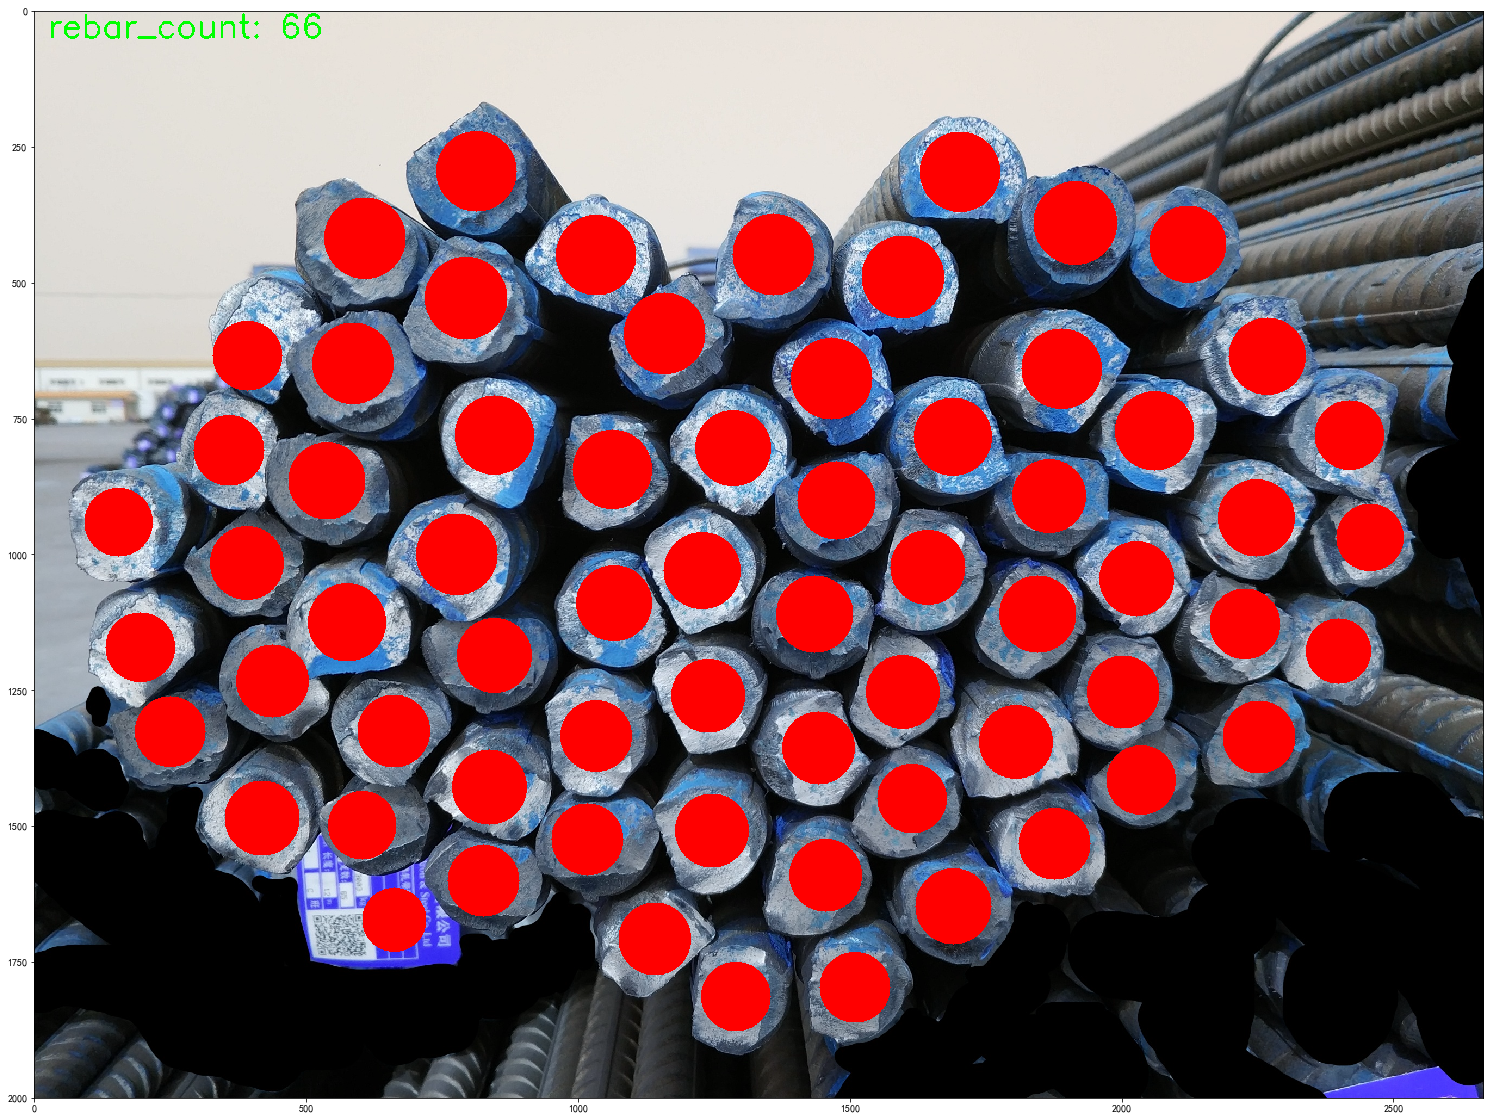

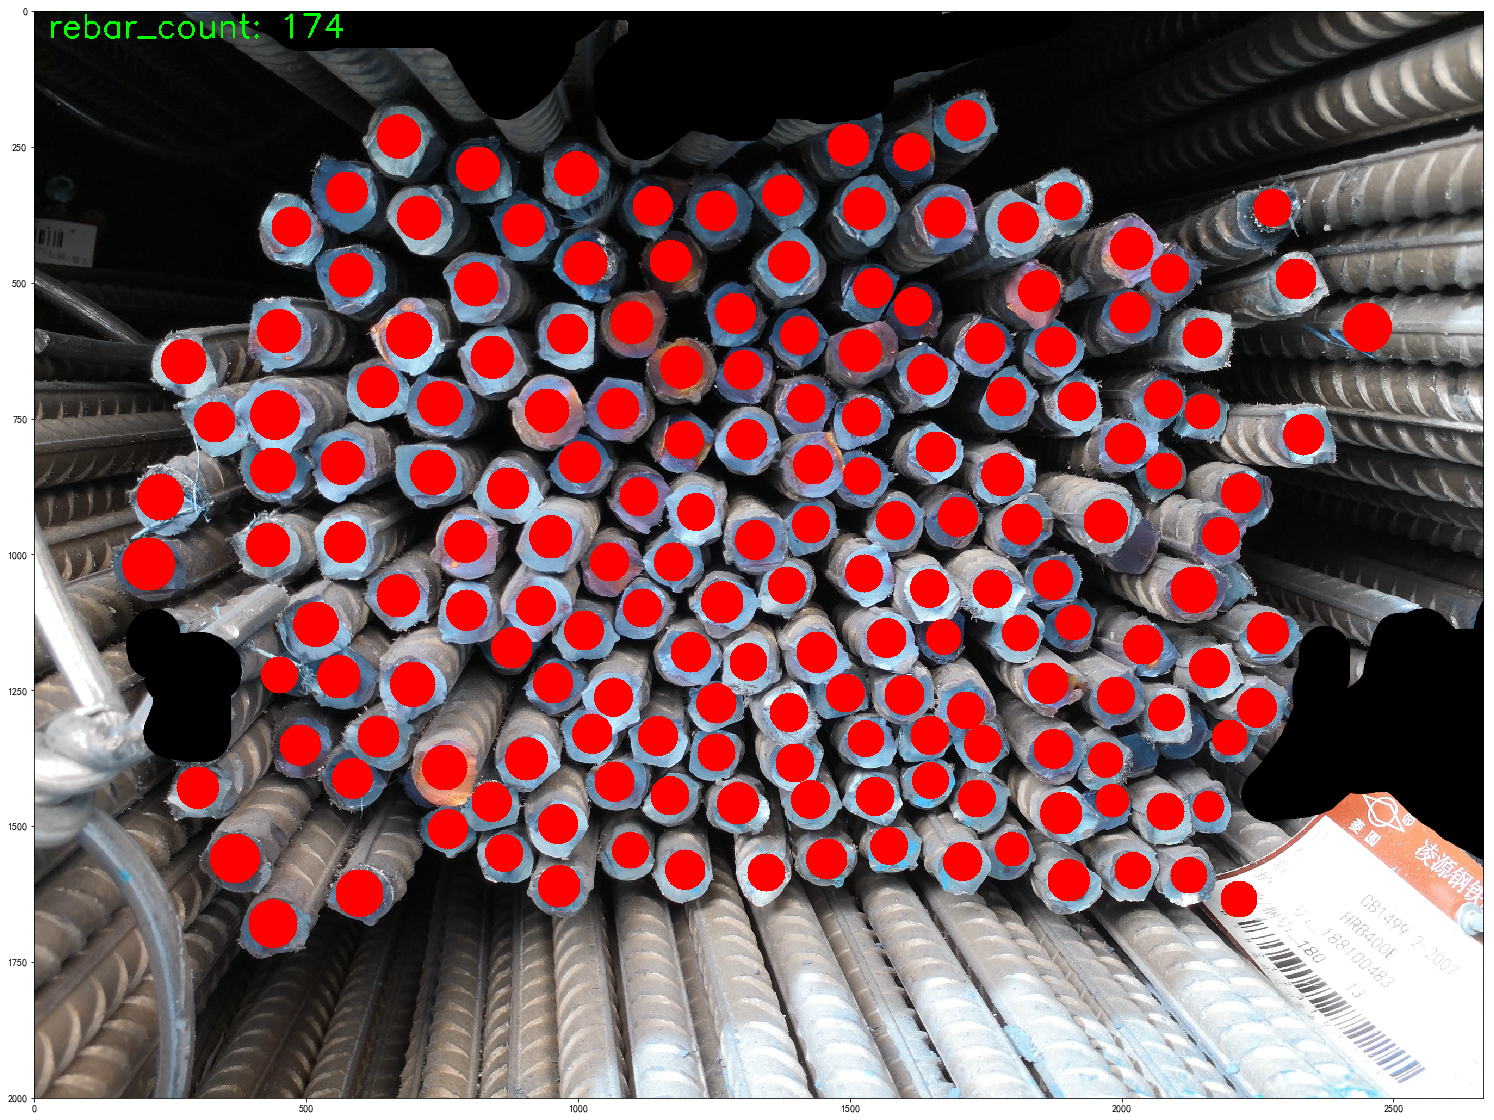

In [12]:
test_img_dir = r'./rebar_count/datasets/test_dataset'  # 待预测的图片目录
files = os.listdir(test_img_dir)
files.sort()
for i, file_name in enumerate(files[:2]):
    image_src = cv2.imread(os.path.join(test_img_dir, file_name))
    detect_bboxes, tim = object_detector.predict(image_src)
    image_draw = image_src.copy()
    rebar_count = 0
    for class_id, class_collection in enumerate(detect_bboxes):
        if len(class_collection) > 0:
            for i in range(class_collection.shape[0]):
                if class_collection[i, -1] > 0.6:
                    pt = class_collection[i]
                    cv2.circle(image_draw, (int((pt[0] + pt[2]) * 0.5), int((pt[1] + pt[3]) * 0.5)), int((pt[2] - pt[0]) * 0.5 * 0.6), (255, 0, 0), -1)
                    rebar_count += 1
    cv2.putText(image_draw, 'rebar_count: %d' % rebar_count, (25, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3)
    plt.figure(i, figsize=(30, 20))
    plt.imshow(image_draw)
    plt.show()